# PyTorch implementation of METRIC LEARNING WITH A DAPTIVE DENSITY DISCRIMINATION

Please reproduce the method described in this paper https://arxiv.org/pdf/1511.05939v2 on the CIFAR-10 dataset (https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html). You should use Pytorch as the machine learning library. Note that there are already some Pytorch implementations of this paper available online on GitHub. You can reuse them if you like but there might be some bugs, as these might not be official implementations, so I suggest that you understand the method first from the paper so that you can fix any bugs in these code bases. If you use any of these publicly available implementations, please state the source, and any bugs you fixed or any modifications you made to run it on the CIFAR-10 dataset. I suggest training the model for ~50 epochs for the final results (after you have tested the implementation). If timing is an issue, you can run it for a lesser number of epochs, but state it clearly in a short report. Additionally, you can also reduce the number of training images for faster training. CIFAR-10 has 10 object classes with each class containing 10000 images. You can use 500 images per class for faster training and convergence. Again, if you use a lesser number of images, please state it in the report. You should report any explanations, results, and graphs in the same report. 




After you have been able to reproduce the method on CIFAR-10, I would like you to modify this code to train the model continually. For this, instead of training your model once on the complete CIFAR-10 dataset, you will divide the dataset into 5 separate sets, with each set containing data for 2 classes. Train your model incrementally on the training data of all the sets in 5 increments. In each increment, train your model on the training set of that increment only and not any previous increments. For example, in the 3rd increment, train your model on the training set of the 3rd set alone. After training in each increment, evaluate your model on the test set of all the sets used so far. For example, after training in the 3rd increment, evaluate your model on the test set of the first 3 sets. Report your model's training accuracy for 5 increments. [You can read more about continual learning here: https://wiki.continualai.org/the-continualai-wiki/introduction-to-continual-learning, and here https://openaccess.thecvf.com/content_CVPRW_2020/papers/w15/Ayub_Cognitively-Inspired_Model_for_Incremental_Learning_Using_a_Few_Examples_CVPRW_2020_paper.pdf].    

The attached document/report does not have to be exhaustive. You only need to include the requested details. The Python code can be submitted as a jupyter notebook. You could also choose to have your explanations in the jupyter notebook rather than a separate pdf file. You can take 10 days to complete this task, so please submit the final set of files by October 13, 11:59 PM (EST). You can use Google Colab of Kaggle's free GPU if you do not have access anywhere else.

In [ ]:
import torch
import torch.nn.functional as F

def _pdist(a, b=None):
    sq_sum_a = torch.sum(a**2, dim=1)
    if b is None:
        return -2 * torch.matmul(a, a.T) + sq_sum_a.unsqueeze(1) + sq_sum_a.unsqueeze(0)
    sq_sum_b = torch.sum(b**2, dim=1)
    return -2 * torch.matmul(a, b.T) + sq_sum_a.unsqueeze(1) + sq_sum_b.unsqueeze(0)


def softmargin_triplet_loss(features, labels, create_summaries=True):
    """Softmargin triplet loss.

    See::

        Hermans, Beyer, Leibe: In Defense of the Triplet Loss for Person
        Re-Identification. arXiv, 2017.

    Parameters
    ----------
    features : torch.Tensor
        A matrix of shape NxM that contains the M-dimensional feature vectors
        of N objects (floating type).
    labels : torch.Tensor
        The one-dimensional array of length N that contains for each feature
        the associated class label (integer type).
    create_summaries : Optional[bool]
        If True, creates summaries to monitor training behavior.

    Returns
    -------
    torch.Tensor
        A scalar loss tensor.

    """
    eps = torch.tensor(1e-5, dtype=torch.float32)
    nil = torch.tensor(0., dtype=torch.float32)
    almost_inf = torch.tensor(1e+10, dtype=torch.float32)

    squared_distance_mat = _pdist(features)
    distance_mat = torch.sqrt(torch.maximum(nil, eps + squared_distance_mat))
    label_mat = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()

    positive_distance = torch.max(label_mat * distance_mat, dim=1)[0]
    negative_distance = torch.min((label_mat * almost_inf) + distance_mat, dim=1)[0]
    loss = F.softplus(positive_distance - negative_distance)

    if create_summaries:
        fraction_invalid_pdist = torch.mean((squared_distance_mat <= -eps).float())
        fraction_active_triplets = torch.mean((loss >= 1e-5).float())
        embedding_squared_norm = torch.mean(torch.sum(features**2, dim=1))
        mean_distance = torch.mean(distance_mat)
        mean_positive_distance = torch.mean(positive_distance)
        mean_negative_distance = torch.mean(negative_distance)

        print(f"Fraction Invalid pdist: {fraction_invalid_pdist}")
        print(f"Fraction Active Triplets: {fraction_active_triplets}")
        print(f"Mean Squared Feature Norm: {embedding_squared_norm}")
        print(f"Mean Feature Distance: {mean_distance}")
        print(f"Mean Positive Distance: {mean_positive_distance}")
        print(f"Mean Negative Distance: {mean_negative_distance}")

    return torch.mean(loss)


def magnet_loss(features, labels, margin=1.0, unique_labels=None):
    """Simple unimodal magnet loss.

    See::

        Rippel, Paluri, Dollar, Bourdev: Metric Learning With Adaptive
        Density Discrimination. ICLR, 2016.

    Parameters
    ----------
    features : torch.Tensor
        A matrix of shape NxM that contains the M-dimensional feature vectors
        of N objects (floating type).
    labels : torch.Tensor
        The one-dimensional array of length N that contains for each feature
        the associated class label (integer type).
    margin : float
        A scalar margin hyperparameter.
    unique_labels : Optional[torch.Tensor]
        Optional tensor of unique values in `labels`. If None given, computed
        from data.

    Returns
    -------
    torch.Tensor
        A scalar loss tensor.

    """
    nil = torch.tensor(0., dtype=torch.float32)
    one = torch.tensor(1., dtype=torch.float32)
    minus_two = torch.tensor(-2., dtype=torch.float32)
    eps = torch.tensor(1e-4, dtype=torch.float32)
    margin = torch.tensor(margin, dtype=torch.float32)

    if unique_labels is None:
        unique_labels = torch.unique(labels, return_inverse=False)
    
    y_mat = (labels.unsqueeze(1) == unique_labels.unsqueeze(0)).float()

    num_per_class = y_mat.sum(dim=0)
    class_means = torch.sum(y_mat.T.unsqueeze(-1) * features.unsqueeze(0), dim=1) / num_per_class.unsqueeze(-1)

    squared_distance = _pdist(features, class_means)
    num_samples = labels.shape[0]
    variance = torch.sum(y_mat * squared_distance) / (num_samples - one)

    const = one / (minus_two * (variance + eps))
    linear = const * squared_distance - y_mat * margin

    maxi = torch.max(linear, dim=1, keepdim=True)[0]
    loss_mat = torch.exp(linear - maxi)

    a = torch.sum(y_mat * loss_mat, dim=1)
    b = torch.sum((one - y_mat) * loss_mat, dim=1)
    loss = torch.maximum(nil, -torch.log(eps + a / (eps + b)))
    
    return torch.mean(loss), class_means, variance


In [ ]:
# https://github.com/vithursant/MagnetLoss-PyTorch/blob/master/datasets/load_dataset.py



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

from datasets.fashion import FASHION

import numpy
from utils.sampler import SubsetSequentialSampler

def load_dataset(args):
	'''
		Loads the dataset specified
	'''

	# CIFAR-10 dataset
	if args.cifar10:
		# Data
		print('==> Preparing data..')
		transform_train = transforms.Compose([
		    transforms.RandomCrop(32, padding=4),
		    transforms.RandomHorizontalFlip(),
		    transforms.ToTensor(),
		    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
		])

		transform_test = transforms.Compose([
		    transforms.ToTensor(),
		    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
		])

		trainset = CIFAR10(root='./data', train=True, transform=transform_train, download=True)
		testset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)


	# Deep Metric Learning
	if args.magnet_loss:
		n_train = len(trainset)
		train_sampler = SubsetSequentialSampler(range(len(trainset)), range(args.batch_size))
		trainloader = DataLoader(trainset,
								 batch_size=args.batch_size,
								 shuffle=False,
								 num_workers=1,
								 sampler=train_sampler)

		testloader = DataLoader(testset,
								batch_size=args.batch_size,
								shuffle=True,
								num_workers=1)
	# Random sampling
	else:
		n_train = len(trainset)
		trainloader = DataLoader(trainset,
								 batch_size=args.batch_size,
								 shuffle=True,
								 num_workers=4)

		testloader = DataLoader(testset,
								batch_size=args.batch_size,
								shuffle=True,
								num_workers=4)

	return trainloader, testloader, trainset, testset, n_train



In [6]:
from sklearn.cluster            import KMeans

In [3]:
!python -m pip list

Package                   Version
------------------------- --------------
anyio                     4.6.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.3.2
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.6
decorator                 5.1.1
defusedxml                0.7.1
dronecan                  1.0.26
empy                      3.3.4
entrypoints               0.4
exceptiongroup            1.2.2
executing                 2.1.0
fastjsonschema            2.20.0
filelock                  3.13.1
flake8           

In [5]:
!conda install scikit-learn -y

/home/koffi/anaconda3/lib/python3.12/site-packages/conda/base/context.py:982: FutureWarning: Adding 'defaults' to the channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly via 'conda config --add channels <name>', e.g. 'conda config --add channels defaults'.
  deprecated.topic(
/home/koffi/anaconda3/lib/python3.12/site-packages/conda/base/context.py:982: FutureWarning: Adding 'defaults' to the channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly via 'conda config --add channels <name>', e.g. 'conda config --add channels defaults'.
  deprecated.topic(
Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/koffi/anaconda3/envs/CV

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    packa

In [ ]:
python magnet_loss_test.py --lr 1e-4 --batch-size 64 --mnist --magnet-loss

In [ ]:
python train_magnet_new.py --lr 1e-4 --batch-size 64 --mnist --magnet-loss

In [11]:
!python train_magnet_new.py

Namespace(save_epoch=10, eval_epoch=3, eval_step=1000, log_rate=10, workers=7, world_size=1, num_epochs=100, embedding_size=512, lr=0.1, momentum=0.9, weight_decay=0.0001, optimizer='sgd', annealing_factor=1.0, dataset='cifar10', model='inception', experiment_name='MagnetTest', loss='softmax', evaluate_only=False, evaluate_train=False, resume=None, dist_url='tcp://224.66.41.62:23456', dist_backend='gloo', M=8, K=8, L=8, D=4, GAP=4, NUM_BATCHES=100)

Experiment path is :  /home/koffi/Desktop/PhD_Applications_Documents/Concordia/prof_Ayub_Task/experiments/cifar10/exp_10_11_18_00_06_cifar10_MagnetTest
#############  Read in Database   ##############
Generating Datasets
==> Preparing data..
100.0%
Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Generating Data Loaders
Time taken:  122.13280749320984 seconds
######## Initiate Model and Optimizer   ##############
/home/koffi/Desktop/PhD_Applications_Documents/Concordia/prof_Ayub_Task/models/magnetIn

In [12]:
!pwd

/home/koffi/Desktop/PhD_Applications_Documents/Concordia/prof_Ayub_Task


In [10]:
!ls


Coding_Task.ipynb  magnet_cifar10.py  train_magnet_new.py  util
dataset.py	   magnet.py	      train_softmax.py
datasets	   models	      train_triplet.py
Draft.ipynb	   softmax.py	      triplet.py


In [ ]:
FileNotFoundError: [Errno 2] No such file or directory: 'experiments/imagenet2012/exp_04_13_14_23_40_imagenet2012_pretrain_imagenet/model@epoch2.pkl'

In [ ]:
FileNotFoundError: [Errno 2] No such file or directory: '/z/dat/ImageNet_2012/validation'


In [15]:
from tensorboardX               import SummaryWriter    as Logger

In [14]:
!pip install tensorboardX

In [20]:
import torch

# After training or validation
# del variable_name  # Replace with actual variable names
torch.cuda.empty_cache()

In [ ]:
/experiments/imagenet2012/exp_10_12_17_10_01_imagenet2012_Test

In [21]:
!conda install -c conda-forge visdom -y


/home/koffi/anaconda3/lib/python3.12/site-packages/conda/base/context.py:969: FutureWarning: Adding 'defaults' to channel list implicitly. is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly via 'conda config --add channels <name>', e.g. 'conda config --add channels defaults'.
  deprecated.topic(
Retrieving notices: ...working... done
/home/koffi/anaconda3/lib/python3.12/site-packages/conda/base/context.py:969: FutureWarning: Adding 'defaults' to channel list implicitly. is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly via 'conda config --add channels <name>', e.g. 'conda config --add channels defaults'.
  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/koffi/anaconda3/envs/CV

  added / updated specs:
    - visdom


The following packages wil

In [23]:
from visdom import Visdom

In [24]:
!python -m visdom.server

Checking for scripts.
It's Alive!
INFO:root:Application Started
INFO:root:Working directory: /home/koffi/.visdom
You can navigate to http://localhost:8097
ERROR:tornado.general:Could not open static file '/home/koffi/anaconda3/envs/CV/lib/python3.12/site-packages/visdom/user/style.css'
INFO:tornado.access:200 GET / (::1) 9.04ms
INFO:tornado.access:200 GET /static/css/bootstrap.min.css?v=e8c5daf01eae68ed7c1e277a6e544c7ad108a0fa877fb531d6d9f2210769b7da88e4e002c7b0be3b72154ebf7cbf01a795c8342ce2dad368bd6351e956195f8b (::1) 2.72ms
INFO:tornado.access:200 GET /static/js/jquery.min.js?v=53a2b560b20551672fbb0e6e72632d4fd1c7e2dd2ecf7337ebaaab179cb8be7c87e9d803ce7765706bc7fcbcf993c34587cd1237de5a279aea19911d69067b65 (::1) 0.63ms
INFO:tornado.access:200 GET /static/css/react-resizable-styles.css?v=a5ba57f67c45b93ccf0e85aee677363a9267ca450452524278aa2538934caa2d425b3ad9de535608f5983729ff25fb9edc98b796cd639d6e4633e5d688c59309 (::1) 0.95ms
INFO:tornado.access:200 GET /static/css/react-grid-layout-st

In [ ]:
Experiment path is :  /home/koffi/Desktop/PhD_Applications_Documents/Concordia/prof_Ayub_Task/experiments/cifar10/exp_10_13_13_29_41_cifar10_MagnetTest

In [ ]:
python -m visdom.server

In [1]:
import pickle


In [ ]:

    # def plot(self, var_name, split_name, x, y):
    #     if var_name not in self.plots:
    #         self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
    #             legend=[split_name],
    #             title=var_name,
    #             xlabel='Epochs',
    #             ylabel=var_name
    #         ))
    #     else:
    #         self.viz.scatter(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name)



In [1]:
from visdom import Visdom
import numpy as np

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    
    def plot(self, var_name, split_name, x, y):
        # Create a 2D array for X with shape (1, 2)
        X = np.array([[x, y]])
        
        # Convert y to an integer for Y
        Y_value = int(y)
        Y = np.array([[Y_value]])

        # Debugging: Print current state
        print(f"Debug: Raw y value: {y}, Y_value: {Y_value}")

        # Ensure the legend is correctly set up
        if var_name not in self.plots:
            # Create a new plot with a single entry for the legend
            self.plots[var_name] = self.viz.scatter(X=X, Y=Y, env=self.env, opts=dict(
                legend=[split_name],  # Initialize with single entry
                title=var_name,
                xlabel='X-axis',
                ylabel='Y-axis'
            ))
            print(f"Debug: Created new plot for {var_name} with legend: {[split_name]}")
        else:
            # Check if split_name already exists in the legend
            if split_name not in self.plots[var_name]['opts']['legend']:
                self.plots[var_name]['opts']['legend'].append(split_name)
                print(f"Debug: Added '{split_name}' to legend.")

            # Print current legend size for debugging
            current_legend_size = len(self.plots[var_name]['opts']['legend'])
            print(f"Debug: Current legend size: {current_legend_size}")

            # Validate Y_value against number of legend entries
            if Y_value >= current_legend_size:
                raise ValueError(f"Y value {Y_value} exceeds the number of legend entries ({current_legend_size}).")

            # Update existing scatter plot
            self.viz.scatter(X=X, Y=Y, env=self.env, win=self.plots[var_name], update='append')
            print(f"Debug: Updated plot for {var_name}")

# Example usage:
plotter = VisdomLinePlotter()
plotter.plot('loss', 'train_step', 1, 1)  # Use a fixed value for testing

Debug: Raw y value: 1, Y_value: 1


AssertionError: Y should be one-dimensional

In [ ]:
plotter.plot('loss', 'train_step', i, 0)  # Use a fixed value for testing

In [3]:
!pip uninstall visdom -y

Found existing installation: visdom 0.1.7
Uninstalling visdom-0.1.7:
  Successfully uninstalled visdom-0.1.7


In [4]:
# !pip install visdom==0.1.7

!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408197 sha256=44f2960dbd0224463cd2193bb7c06d03fa2d4799327e7925f931fb06d6bcf7d4
  Stored in directory: /home/koffi/.cache/pip/wheels/37/6c/38/64eeaa310e325aacda723e6df1f79ab5e9f31ba195264e04a8
Successfully built visdom


In [2]:
# !visdom --version

/bin/bash: line 1: visdom: command not found


# Part2

In [ ]:
class magnet_CIFAR10(data.Dataset):
    # ... (existing code remains unchanged)

    def get_classes(self, class_indices):
        """Return a subset of the dataset containing only the specified classes."""
        mask = np.isin(self.labels, class_indices)
        self.data = self.data[mask]
        self.labels = self.labels[mask]
        self.read_order = range(len(self.data))  # Reset read order for new dataset

    # ... (rest of the class remains unchanged)


In [ ]:
from datasets import ImageNet, magnet_CIFAR10

# Define the class indices for each increment
class_sets = [
    [0, 1],  # Classes 0 and 1
    [2, 3],  # Classes 2 and 3
    [4, 5],  # Classes 4 and 5
    [6, 7],  # Classes 6 and 7
    [8, 9],  # Classes 8 and 9
]

def main(args):
    curr_time = time.time()
    
    global plotter
    plotter = VisdomLinePlotter(env_name=args.name)

    print("#############  Read in Database   ##############")
    train_loader, valid_loader = get_loaders()                     

    print("Time taken:  {} seconds".format(time.time() - curr_time))
    curr_time = time.time()

    print("######## Initiate Model and Optimizer   ##############")  
    model = magnetInception(args.embedding_size)

    # Load the model, criterion, optimizer, etc. as before...

    # Loop through each increment
    for increment in range(len(class_sets)):
        print(f"Training increment {increment + 1} with classes {class_sets[increment]}")

        # Update dataset to only include the current class set
        train_loader.dataset.get_classes(class_sets[increment])
        
        # Reset the model for each increment if needed
        model.train()  # Ensure model is in training mode

        # Training loop for the current increment
        for epoch in range(args.num_epochs):
            order = define_order(cluster_assignment, cluster_centers, loss_vector / loss_count)
            train_loader.dataset.update_read_order(order)

            loss_vector, loss_count, stdev = train_step(
                model=model,
                train_loader=train_loader,
                criterion=criterion,
                epoch=epoch,
                optimizer=optimizer,
                step=epoch * len(train_loader),
                valid_loader=None,  # No validation during increment training
                assignment=None,
                loss_vector=loss_vector,
                loss_count=loss_count
            )

        # After training the current increment, evaluate on all previous increments
        for eval_increment in range(increment + 1):
            # Update the dataset to include all classes up to the current increment
            eval_classes = [cls for sublist in class_sets[:eval_increment + 1] for cls in sublist]
            train_loader.dataset.get_classes(eval_classes)

            # Evaluate the model
            eval_loss, eval_accuracy = eval_step(
                model=model,
                data_loader=train_loader,
                criterion=criterion,
                step=0,  # Adjust if necessary
                datasplit='valid',
                stdev=stdev,
                cluster_centers=cluster_centers
            )

            print(f"Evaluation after increment {increment + 1} on classes {eval_classes}: Loss = {eval_loss}, Accuracy = {eval_accuracy}")

    print("Training completed for all increments.")


In [ ]:























bbbbbbbbbbbbb

In [4]:
def simulate_distances(drone_positions, anchors):
    distances = []
    noise_level = 0.1  # Adjust noise level as needed
    for pos in drone_positions:
        dists = np.linalg.norm(anchors - pos, axis=1) + np.random.normal(0, noise_level, size=anchors.shape[0])
        distances.append(dists)
    return np.array(distances)

In [5]:
def trilaterate(anchors, distances):
    A = []
    b = []
    
    for i in range(len(anchors)):
        x_i, y_i, z_i = anchors[i]
        d_i = distances[i]
        
        # Create equations based on the trilateration formula
        A.append([2 * (x_i - anchors[0][0]), 
                   2 * (y_i - anchors[0][1]), 
                   2 * (z_i - anchors[0][2])])
        b.append(d_i**2 - np.linalg.norm(anchors[0])**2 + np.linalg.norm([x_i, y_i, z_i])**2)

    A = np.array(A)
    b = np.array(b)

    # Solve the linear system Ax = b
    estimated_position = np.linalg.lstsq(A, b, rcond=None)[0]
    
    return estimated_position

In [6]:
# Define anchor positions (fixed reference points)
anchors = np.array([
    [0, 0, 0],   # Anchor 1
    [10, 0, 0],  # Anchor 2
    [0, 10, 0],  # Anchor 3
])

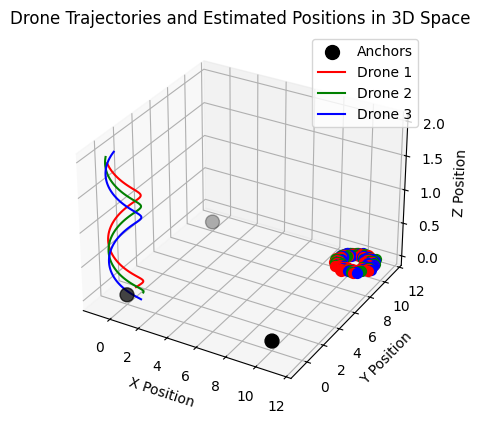

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulated positions of drones over time
time_steps = 100
drone1_positions = np.array([[np.sin(t / 10), np.cos(t / 10), t / 50] for t in range(time_steps)])
drone2_positions = np.array([[np.sin(t / 10 + np.pi/4), np.cos(t / 10 + np.pi/4), t / 50] for t in range(time_steps)])
drone3_positions = np.array([[np.sin(t / 10 + np.pi/2), np.cos(t / 10 + np.pi/2), t / 50] for t in range(time_steps)])

# Define anchor positions (fixed reference points)
anchors = np.array([
    [0, 0, 0],   # Anchor 1
    [10, 0, 0],  # Anchor 2
    [0, 10, 0],  # Anchor 3
])

# Create a figure for plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot anchor positions
ax.scatter(anchors[:,0], anchors[:,1], anchors[:,2], color='k', s=100, label='Anchors')

# Loop through time steps and localize each drone
for t in range(time_steps):
    # Simulate distance measurements for each drone
    distances1 = simulate_distances([drone1_positions[t]], anchors)[0]
    distances2 = simulate_distances([drone2_positions[t]], anchors)[0]
    distances3 = simulate_distances([drone3_positions[t]], anchors)[0]

    # Localize drones using trilateration
    estimated_position1 = trilaterate(anchors, distances1)
    estimated_position2 = trilaterate(anchors, distances2)
    estimated_position3 = trilaterate(anchors, distances3)

    # Plotting estimated positions
    ax.scatter(*estimated_position1, color='r', s=50)
    ax.scatter(*estimated_position2, color='g', s=50)
    ax.scatter(*estimated_position3, color='b', s=50)

# Plot actual drone trajectories
ax.plot(drone1_positions[:, 0], drone1_positions[:, 1], drone1_positions[:, 2], label='Drone 1', color='r')
ax.plot(drone2_positions[:, 0], drone2_positions[:, 1], drone2_positions[:, 2], label='Drone 2', color='g')
ax.plot(drone3_positions[:, 0], drone3_positions[:, 1], drone3_positions[:, 2], label='Drone 3', color='b')

# Set labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('Drone Trajectories and Estimated Positions in 3D Space')
ax.legend()

# Show plot
plt.show()

In [8]:
!pip install  filterpy

  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=49bc5190c34d902b34a154805e94ae45437fd3e392a3b39bbb941bbfaaa443b0
  Stored in directory: /home/koffi/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


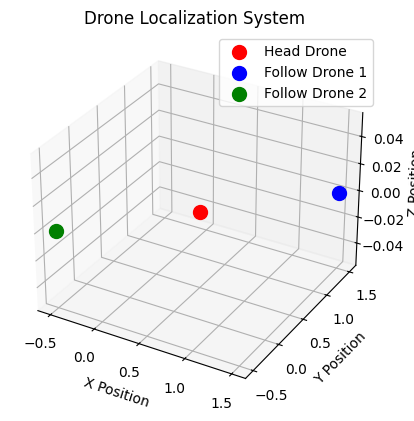

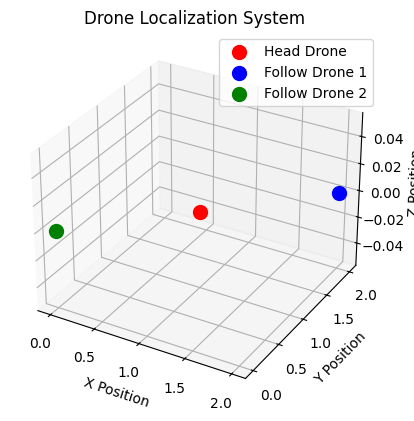

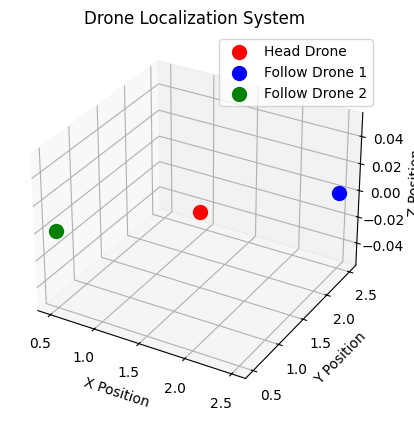

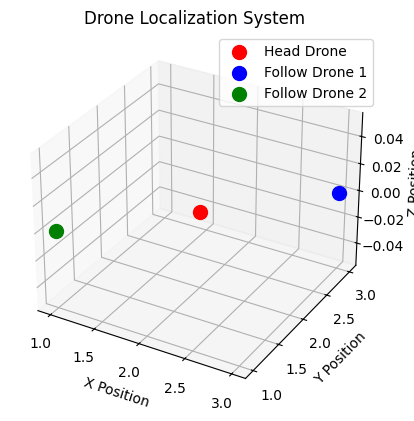

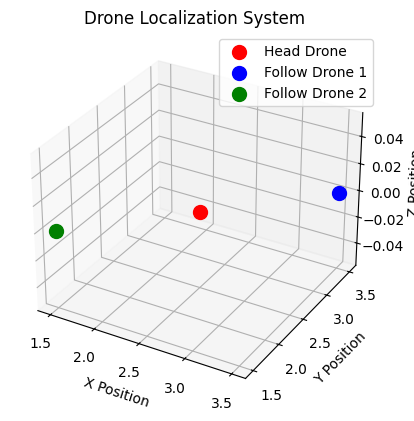

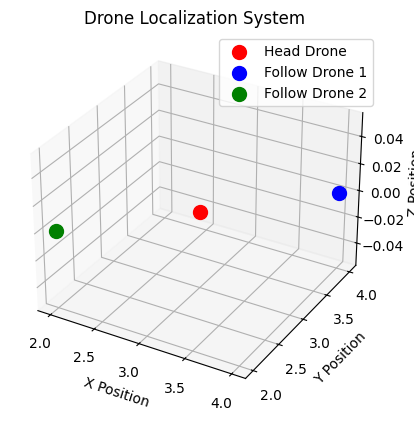

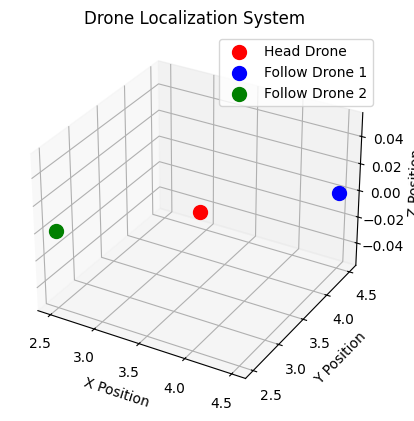

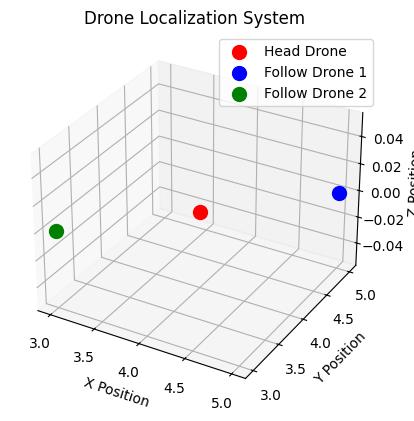

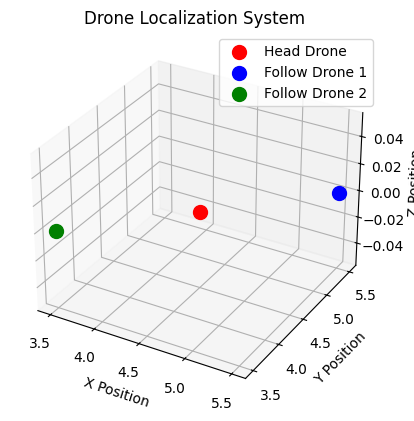

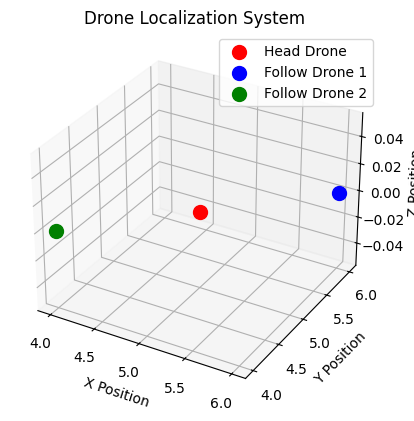

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize drone positions as float arrays
head_drone_pos = np.array([0.0, 0.0, 0.0], dtype=float)  # Head drone at origin
follow_drone_1_pos = np.array([1.0, 1.0, 1.0], dtype=float)  # Initial position of drone 1
follow_drone_2_pos = np.array([-1.0, -1.0, -1.0], dtype=float)  # Initial position of drone 2

# Define a function to update positions based on head drone's position
def update_positions(head_pos):
    # Simple logic to maintain a relative position to the head drone
    follow_drone_1_pos[:] = head_pos + np.array([1.0, 1.0, 0.0])  # Drone 1 follows at (1,1,0)
    follow_drone_2_pos[:] = head_pos + np.array([-1.0, -1.0, 0.0])  # Drone 2 follows at (-1,-1,0)

# Visualization function
def visualize_drones(head_pos, drone_1_pos, drone_2_pos):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot head drone
    ax.scatter(head_pos[0], head_pos[1], head_pos[2], color='red', s=100, label='Head Drone')
    
    # Plot following drones
    ax.scatter(drone_1_pos[0], drone_1_pos[1], drone_1_pos[2], color='blue', s=100, label='Follow Drone 1')
    ax.scatter(drone_2_pos[0], drone_2_pos[1], drone_2_pos[2], color='green', s=100, label='Follow Drone 2')

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title('Drone Localization System')
    ax.legend()

    plt.show()

# Main simulation loop
for t in range(10):  # Simulate for 10 time steps
    head_drone_pos += np.array([0.5, 0.5, 0.0])  # Move head drone in positive X and Y direction
    update_positions(head_drone_pos)  # Update positions of following drones
    visualize_drones(head_drone_pos, follow_drone_1_pos, follow_drone_2_pos)  # Visualize current state

/home/koffi/anaconda3/envs/CV/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


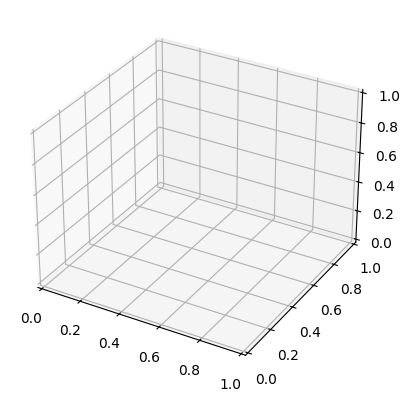

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Drone class definition
class Drone:
    def __init__(self, id, position):
        self.id = id
        self.position = np.array(position)
    
    def update_position(self, leader_position):
        # Simple following logic: move towards the leader's position
        direction = leader_position - self.position
        distance = np.linalg.norm(direction)
        
        if distance > 1:  # Avoid collision by maintaining a minimum distance
            self.position += direction / distance  # Normalize and move towards leader

# Function to move the leader drone randomly
def move_leader(leader):
    leader.position += np.random.randn(3) * 0.5  # Random movement

# Initialize drones
leader_position = np.array([0.0, 0.0, 10.0])  # Leader starts at (0, 0, 10)
drones = [Drone(id=1, position=leader_position.copy())]  # Leader drone

# Add follower drones with random initial positions
for i in range(2):
    drones.append(Drone(id=i + 2, position=leader_position + np.random.rand(3) * 5))

# Set up visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Animation update function
def update(frame):
    move_leader(drones[0])  # Move leader
    
    for drone in drones[1:]:
        drone.update_position(drones[0].position)  # Update follower positions
    
    ax.cla()  # Clear previous frame
    
    # Plotting the current positions of all drones
    for drone in drones:
        ax.scatter(drone.position[0], drone.position[1], drone.position[2], label=f'Drone {drone.id}')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('Drone Trajectories')
    ax.legend()

# Create animation
ani = FuncAnimation(fig, update, frames=50)

plt.show()